In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [2]:
df=pd.read_csv("Fraud.csv")
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

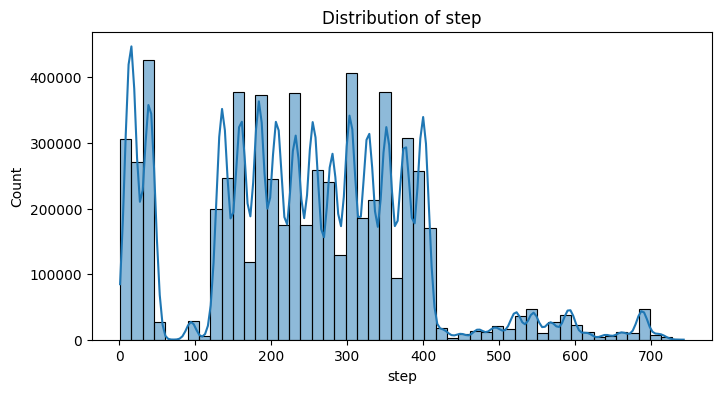

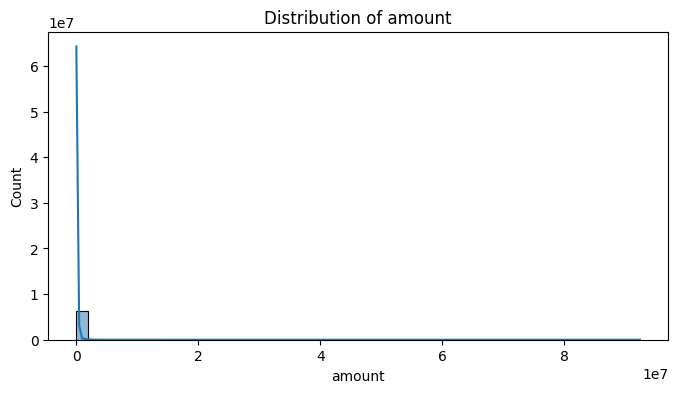

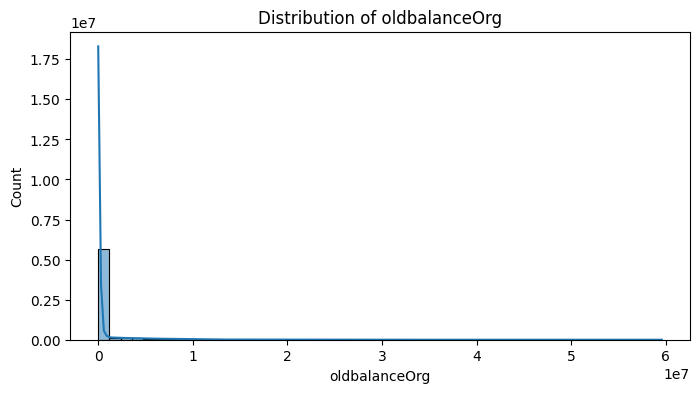

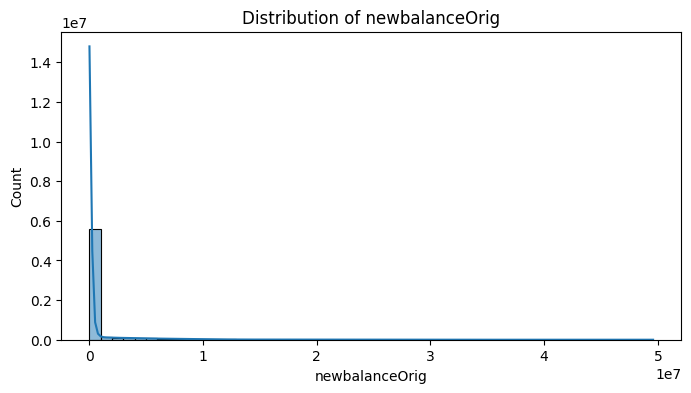

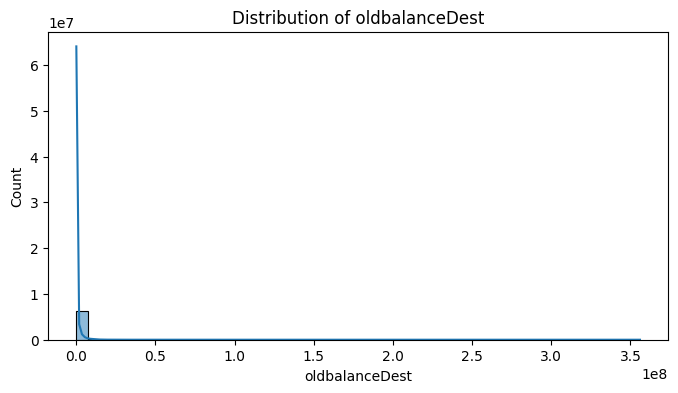

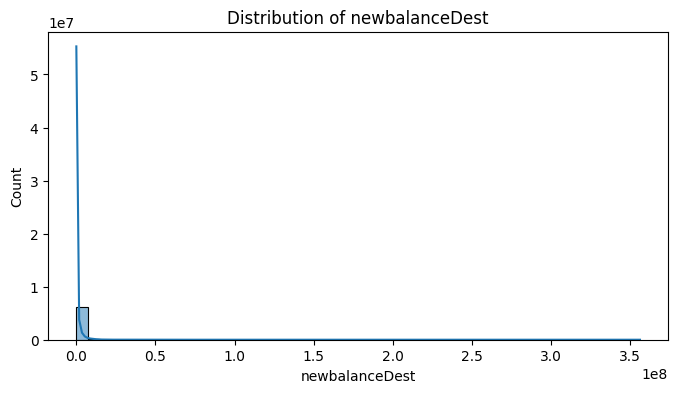

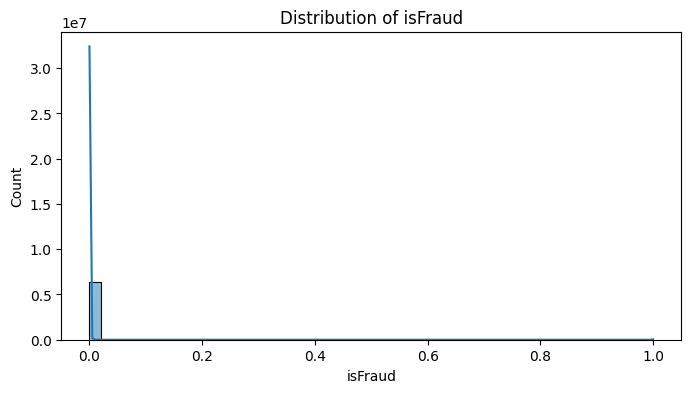

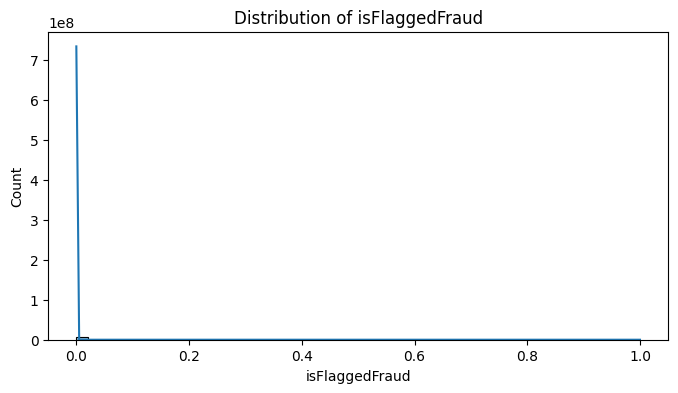

In [6]:
numerical_cols = df.select_dtypes(include='number').columns.tolist()

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


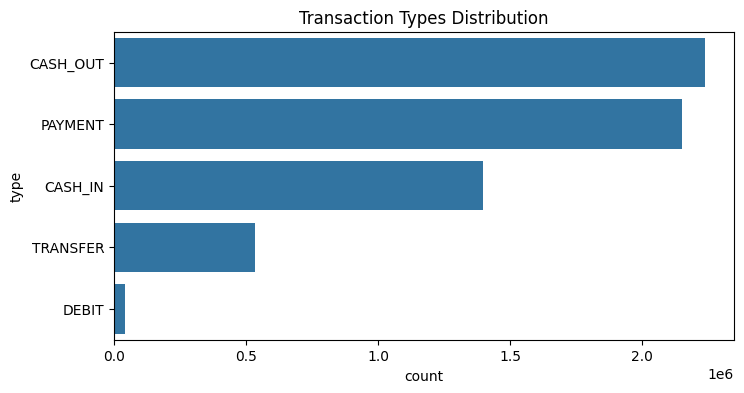

In [7]:
plt.figure(figsize=(8, 4))
sns.countplot(y=df['type'], order=df['type'].value_counts().index)
plt.title('Transaction Types Distribution')
plt.show()


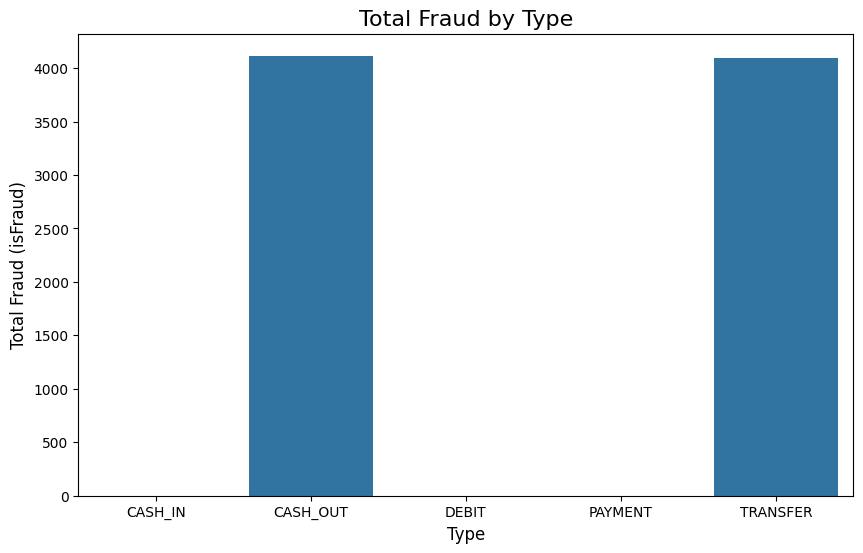

In [8]:
fraud_by_type = df.groupby('type')['isFraud'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_by_type, x='type', y='isFraud')

plt.title('Total Fraud by Type', fontsize=16)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Total Fraud (isFraud)', fontsize=12)
plt.show()


we see that there are frauds in only cash_out and Transfer categories

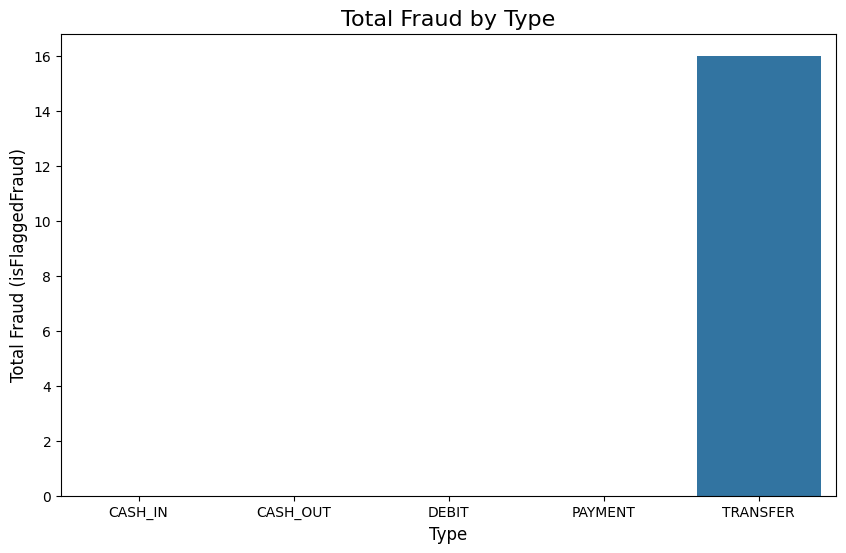

In [9]:
fraud_by_type = df.groupby('type')['isFlaggedFraud'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_by_type, x='type', y='isFlaggedFraud')

plt.title('Total Fraud by Type', fontsize=16)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Total Fraud (isFlaggedFraud)', fontsize=12)
plt.show()

And for isflaggedfraud, theres fraud in only transfer category

# Preprocess

## Handling na values

## Q1

In [10]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Handling Outliers

In [11]:
import pandas as pd
import numpy as np

numerical_cols = df.drop(columns=['isFraud']).select_dtypes(include='number').columns.tolist()

def cap_outliers_iqr(df, columns, factor=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (factor * IQR)
        upper_bound = Q3 + (factor * IQR)

        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

df_clean = cap_outliers_iqr(df, numerical_cols, factor=1.5)

print(df_clean.describe())


               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.422653e+02  1.322667e+05   7.221247e+04    8.872275e+04   
std    1.391004e+02  1.462368e+05   1.024141e+05    1.393412e+05   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    6.035000e+02  5.017193e+05   2.682879e+05    3.606460e+05   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06       6362620.0  
mean     6.003940e+05    7.150404e+05  1.290820e-03             0.0  
std      8.369711e+05    9.673665e+05  3.590480e-02             0.0  
min      0.000000e+00    0.000000e+00  0.000000e+00             0.0  
25%      0.000000e+00    0.000000e+00

## Handling Multi-collinearity

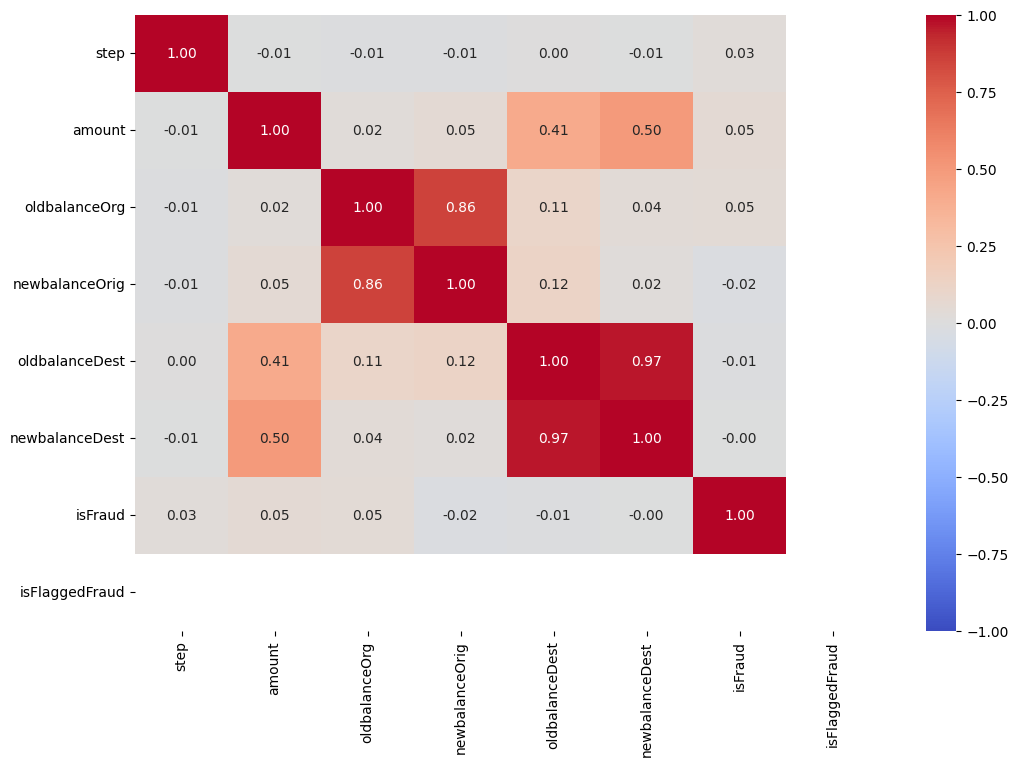

In [12]:
numerical_cols = df_clean.select_dtypes(include='number')

correlation_matrix = numerical_cols.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.show()


'oldbalanceDest', 'newbalanceDest' and 'oldbalanceOrig', 'newbalanceOrig' have high multi-collinearity so we do feture engineering to combine them into one column each.

Possible other methods: PCA, Dropping columns (them)


### Feature Engineering

In [13]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [14]:
df_clean['balance_change_orig'] = df_clean['newbalanceOrig'] - df_clean['oldbalanceOrg']
df_clean['balance_change_dest'] = df_clean['newbalanceDest'] - df_clean['oldbalanceDest']

df_clean = df_clean.drop(columns=['oldbalanceDest', 'newbalanceDest', 'oldbalanceOrg', 'newbalanceOrig'])


In [15]:
df_clean.head()

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,balance_change_orig,balance_change_dest
0,1.0,PAYMENT,9839.64,C1231006815,M1979787155,0,0.0,-9839.64,0.0
1,1.0,PAYMENT,1864.28,C1666544295,M2044282225,0,0.0,-1864.28,0.0
2,1.0,TRANSFER,181.00,C1305486145,C553264065,1,0.0,-181.00,0.0
3,1.0,CASH_OUT,181.00,C840083671,C38997010,1,0.0,-181.00,-21182.0
4,1.0,PAYMENT,11668.14,C2048537720,M1230701703,0,0.0,-11668.14,0.0


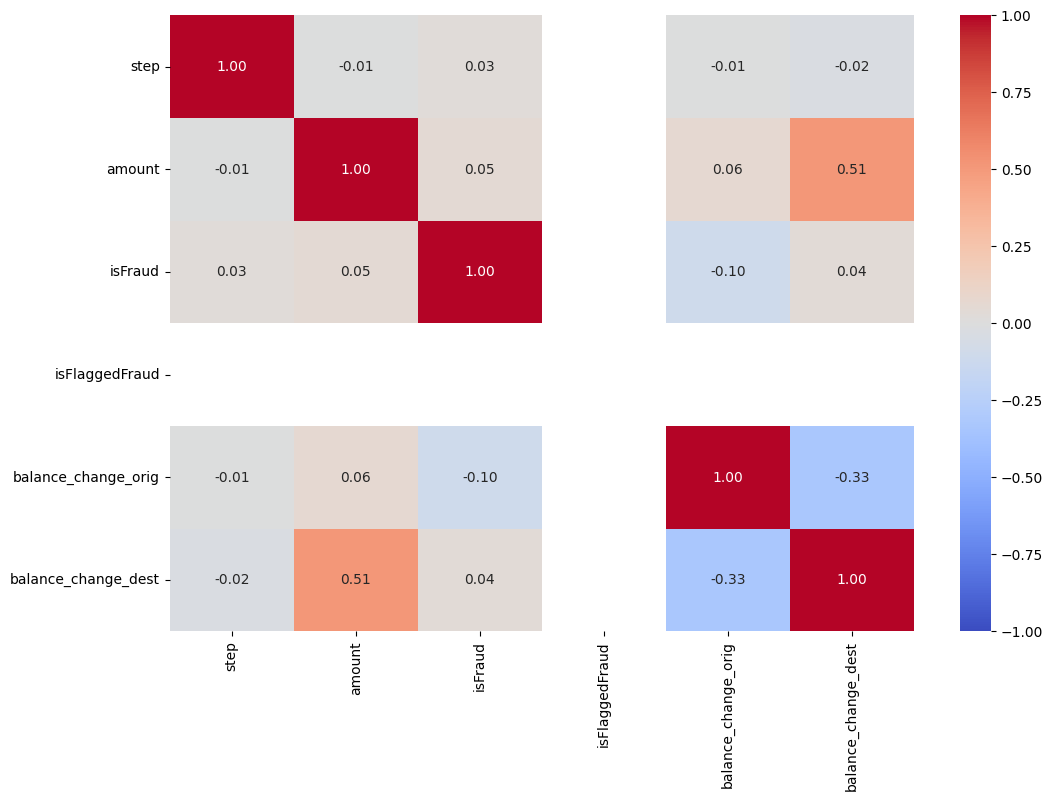

In [16]:
numerical_cols = df_clean.select_dtypes(include='number')

correlation_matrix = numerical_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.show()


In [17]:
df_clean.drop(columns=['nameOrig', 'nameDest','isFlaggedFraud'], inplace=True)

In [18]:
df_clean = pd.get_dummies(df_clean, columns=['type'], drop_first=True)

In [19]:
df_clean.iloc[:,-4:]=df_clean.iloc[:,-4:].astype(int)

C:\Users\wangd\AppData\Local\Temp\ipykernel_19344\323881632.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0          0
1          0
2          0
3          1
4          0
          ..
6362615    1
6362616    0
6362617    1
6362618    0
6362619    1
Name: type_CASH_OUT, Length: 6362620, dtype: int32' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_clean.iloc[:,-4:]=df_clean.iloc[:,-4:].astype(int)
C:\Users\wangd\AppData\Local\Temp\ipykernel_19344\323881632.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0          0
1          0
2          0
3          0
4          0
          ..
6362615    0
6362616    0
6362617    0
6362618    0
6362619    0
Name: type_DEBIT, Length: 6362620, dtype: int32' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_clean.iloc[:

In [20]:
df_clean.isFraud=df_clean.isFraud.astype(int)

## Q3
So I got the above columns with their respective values to get them into numerical values as ML models work better with numerical values.

I removed 'nameOrig', 'nameDest' as they wouldnt contribute to the model a lot as almost each row has a different value of them and therefore there is no pattern in them. 'nameOrig' was unique for almost every row but 'nameDest' had less unique values, 'nameDest' might contribute to the model but deep analysis will be required. But removing them reduces dimensionality problem. 

I removed 'isFlaggedFraud' as it only 16 rows (of one class in type) contain value 1 which is extremely imbalanced class which can lead to issues in modelling. 

# Model Building

## Without Resampling

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df_clean.drop(columns='isFraud'), df_clean['isFraud'], test_size=0.02, random_state=42)

X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))


Accuracy: 0.939412513555566
Confusion Matrix:
 [[59697  3848]
 [    7    75]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     63545
           1       0.02      0.91      0.04        82

    accuracy                           0.94     63627
   macro avg       0.51      0.93      0.50     63627
weighted avg       1.00      0.94      0.97     63627



In [24]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc}')

ROC-AUC Score: 0.8262915276095871


C:\Users\wangd\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced")
dt_clf.fit(X_train, y_train)

y_test_pred = dt_clf.predict(X_test)
print("Test Set Evaluation - Decision Tree:")
print(classification_report(y_test, y_test_pred))


Test Set Evaluation - Decision Tree:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     63545
           1       0.04      1.00      0.08        82

    accuracy                           0.97     63627
   macro avg       0.52      0.98      0.53     63627
weighted avg       1.00      0.97      0.98     63627



In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_clf = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42, tree_method='gpu_hist')
xgb_clf.fit(X_train, y_train)

y_test_pred = xgb_clf.predict(X_test)
print("Test Set Evaluation - XGBoost:")
print(classification_report(y_test, y_test_pred))


C:\Users\wangd\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [23:21:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     63545
           1       0.09      0.95      0.16        82

    accuracy                           0.99     63627
   macro avg       0.54      0.97      0.58     63627
weighted avg       1.00      0.99      0.99     63627



C:\Users\wangd\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [23:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\wangd\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [23:21:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the b

In [27]:
confusion_matrix(y_test, y_test_pred)

array([[62749,   796],
       [    4,    78]], dtype=int64)

In [28]:
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc}')

ROC-AUC Score: 0.998305598682708


In [29]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

cat_clf = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=0, task_type="GPU")
cat_clf.fit(X_train, y_train)

y_test_pred = cat_clf.predict(X_test)
print("Test Set Evaluation - CatBoost:")
print(classification_report(y_test, y_test_pred))


Test Set Evaluation - CatBoost:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     63545
           1       0.05      0.98      0.10        82

    accuracy                           0.98     63627
   macro avg       0.53      0.98      0.54     63627
weighted avg       1.00      0.98      0.99     63627



In [30]:
y_pred_proba = cat_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc}')

ROC-AUC Score: 0.9982623222644218


In [31]:
confusion_matrix(y_test, y_test_pred)

array([[62125,  1420],
       [    2,    80]], dtype=int64)

### Neural Network

In [32]:
y_train = y_train.to_numpy()

In [33]:
class_counts = np.bincount(y_train)
class_weight = {0: 1, 1: class_counts[0] / class_counts[1]}

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Build Neural Network
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=10,
    batch_size=512,
    validation_data=(X_dev_scaled, y_dev),
    class_weight=class_weight,
    callbacks=[early_stopping]
)

# Test Evaluation (final)
y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print("Test Set Evaluation - Neural Network:")
print(classification_report(y_test, y_test_pred))


C:\Users\wangd\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9413 - loss: 0.2493 - val_accuracy: 0.9636 - val_loss: 0.0757
Epoch 2/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.9643 - loss: 0.1393 - val_accuracy: 0.9523 - val_loss: 0.1058
Epoch 3/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9659 - loss: 0.1341 - val_accuracy: 0.9550 - val_loss: 0.1070
Epoch 4/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.9649 - loss: 0.1341 - val_accuracy: 0.9619 - val_loss: 0.0914
Epoch 5/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9658 - loss: 0.1318 - val_accuracy: 0.9783 - val_loss: 0.0524
Epoch 6/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9651 - loss: 0.1301 - val_accuracy: 0.9686 - val_loss: 0.0639
Epoch 7/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - accuracy: 0.9661 - loss: 0.1275 - val_accuracy: 0.9682 - val_loss: 0.0725
Epoch 8/10
12179/12179 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 

## Applying resampling techniques

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize Logistic Regression with class weight balanced (optional with SMOTE)
log_reg = LogisticRegression(random_state=42)

# Fit the model on the resampled training data
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on the dev set
y_dev_pred = log_reg.predict(X_dev_scaled)

# Evaluate the model on the dev set
print("Development Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_dev, y_dev_pred)}")
print("Confusion Matrix:\n", confusion_matrix(y_dev, y_dev_pred))
print("Classification Report:\n", classification_report(y_dev, y_dev_pred))

# Predict on the test set
y_test_pred = log_reg.predict(X_test_scaled)

# Evaluate the model on the test set
print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))


C:\Users\wangd\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\wangd\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Development Set Evaluation:
Accuracy: 0.9378870273158771
Confusion Matrix:
 [[59588  3947]
 [    5    86]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     63535
           1       0.02      0.95      0.04        91

    accuracy                           0.94     63626
   macro avg       0.51      0.94      0.50     63626
weighted avg       1.00      0.94      0.97     63626

Test Set Evaluation:
Accuracy: 0.9395382463419617
Confusion Matrix:
 [[59705  3840]
 [    7    75]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     63545
           1       0.02      0.91      0.04        82

    accuracy                           0.94     63627
   macro avg       0.51      0.93      0.50     63627
weighted avg       1.00      0.94      0.97     63627



## Q2
I started off with simple model, Logistic regression to set a base line for other complex models. I tried applying both resampling and without addressing the imbalanced classes, the output metrics was similar. I applied Logistic Regression as its output is binary (0,1) and 'isFraud' is also binary. It predicts the probability of an output belonging between 0 and 1. Uses a sigmoid function.

Then tried a tree model which builds a tree of decisions on the basis of the data and predicts the class.

Then ensemble methods like XGBoost and CatBoost which combine different models in one and make prediction on basis of multiple model predictions.

A Neural Network which is a black box model which gave similar accuracy.

## Q4
Used F1 score, recall, precision and roc score as metrics as it is helpful for imbalanced classes.
Insights: Precision for Fraud is around 0.06 which is poor, model incorrectly labels many non-fraud transactions as fraud but it is better than not to flag fraud transactions with a recall of 98% for both fraud and non fraud.

ROC-score is also around 98%.

Confusion Matrix also looks good catching most of the fraud transactions and flagging some non-fraud transactions

# Feature Importance

## Important features from each model

### Decision Tree

In [36]:
for i in np.argsort(dt_clf.feature_importances_)[::-1]:
    print(dt_clf.feature_names_in_[i],":",dt_clf.feature_importances_[i])


balance_change_orig : 0.7219765387529468
amount : 0.12097818160862814
balance_change_dest : 0.07455285473350493
type_TRANSFER : 0.04443539368351684
step : 0.014641590219814234
type_CASH_OUT : 0.013107118546123234
type_PAYMENT : 0.010308322455465983
type_DEBIT : 6.439847346225328e-20


Shows the most important features which contribute to predicting "isFraud"

### Logistic Regression

In [37]:
for i in np.argsort(np.abs(log_reg.coef_[0]))[::-1]:
    print(X_test.columns[i], ":", log_reg.coef_[0][i])

type_PAYMENT : -4.760109480932887
type_CASH_OUT : 3.7643683389700264
type_TRANSFER : 2.7947586650465275
balance_change_orig : -1.910252208069822
amount : -0.7920689495760307
type_DEBIT : -0.7659572531154015
step : 0.48958862261890845
balance_change_dest : -0.08188181713287612


In [38]:
from sklearn.inspection import permutation_importance

# Assuming 'model' is your trained model, and X_test, y_test are your test set and labels
results = permutation_importance(cat_clf, X_test, y_test, n_repeats=20)

for i in np.argsort(results.importances_mean)[::-1]:
    print(X_test.columns[i],":",results.importances_mean[i])

balance_change_dest : 0.01980055636757977
type_TRANSFER : 0.011942257217847752
step : 0.0005092177849026269
type_DEBIT : 0.0
type_PAYMENT : -0.00509689282851622
amount : -0.006568752259261068
type_CASH_OUT : -0.01124444025335164
balance_change_orig : -0.012731230452480868


In [39]:
from sklearn.inspection import permutation_importance

# Assuming 'model' is your trained model, and X_test, y_test are your test set and labels
results = permutation_importance(xgb_clf, X_test, y_test, n_repeats=20)

for i in np.argsort(results.importances_mean)[::-1]:
    print(X_test.columns[i],":",results.importances_mean[i])

balance_change_dest : 0.010306159334873565
step : 0.0010978043912175939
type_TRANSFER : 0.0004966445062630775
type_DEBIT : -3.3004856428875406e-05
type_PAYMENT : -0.003456079966052128
amount : -0.005836358778506018
type_CASH_OUT : -0.006489383437848684
balance_change_orig : -0.0075070331777389865


## Q5
Based on all of the above observations, balance_change_dest, type_TRANSFER and step are the most contributing factors in predicting isFraud.

## Q6
factor 'balance change dest' makes sense as for a fraud high amount of change in acoount raises suspicion and is considered an anomaly. Person might have created a new account to transfer large amount of money so he is not detectable. Although this would require more analysis.

factor 'type_TRANSFER' can help in identifying fraud which can be different in different cases. this helps commiting fraud quickly. 

factor 'step' can help when small amounts of money is being debited or credited on a longer basis so no anamoly/outlier is raised. this would require more analysis.

## Q7
1. Keep on updating the data and retraining the model which will keep the model updated with new fraud methods.
2. Rollback: revert to previous state when update fails.
3. Evaluate risks associated with the update, such as downtime and data breaches.
4. Backup: Ensure backup of critical systems and data. Store copies of data in different storage hardwares or facilities incase one system fails, data is not lost.
5. Test the update in a controlled enviroment before applying it.
6. Update during off peak hours

## Q8
1. Monitoring and logging of metrics.
2. Check for succes of each in a controlled enviroment.
3. Post update, check functionality and performance of updated system.